In [5]:
library(naniar)
library(tidyverse)
library(yardstick)
library(ranger)
library(ppsr)
library(minerva)
library(randomForest)

## Temp -- Combine datasets, create new train test

Can be skipped

In [1]:
dataDir='/home/jupyter/Domains_202003/data/output/dp_datapull_20210223/expiry_20191006_20210104_train1.RDS'
train1 <- readRDS(dataDir)
dataDir='/home/jupyter/Domains_202003/data/output/dp_datapull_20210223/expiry_20191006_20210104_train2.RDS'
train2 <- readRDS(dataDir)
dataDir='/home/jupyter/Domains_202003/data/output/dp_datapull_20210223/expiry_20191006_20210104_test.RDS'
test <- readRDS(dataDir)


In [2]:
for (col in colnames(train2)) {
    if (grepl("date", col)) {
        print(col)
        if (col == 'scandate') {
            train2[,col] <- as.POSIXct(train2[,col], format="%Y-%m-%d %H:%M:%S UTC")
        }
        else {
            train2[,col] <- as.Date(train2[,col], format="%Y-%m-%d")
        }
    }
}

[1] "expiry_date"
[1] "creation_date"
[1] "renew_date"
[1] "download_date"
[1] "scandate"
[1] "max_date"


In [3]:
# Common columns
common <- names(train1)[names(train2) %in% names(train1)]

# Fix data types
train2[common] <- lapply(common, function(x) {
  match.fun(paste0("as.", class(train1[[x]])[1]))(train2[[x]])
})

In [20]:
# Combine data; add relevant columns
all_data <- bind_rows(train1, train2, test) %>% arrange(expiry_date)
all_data <- all_data %>% 
                filter(!is.na(gibb_score)) %>% # remove where gibb_score, etc. are NA
                mutate (reg_arpt = ifelse(reg_arpt <= 0, 0.0001,reg_arpt), # add necessary columns
                                   log_reg_arpt = log(reg_arpt),
                                   tld_registrar_index = tolower(paste(tld, reseller,sep="")))

In [21]:
row_split1 <- round(0.4 * nrow(all_data))
row_split2 <- round(0.8 * nrow(all_data))

date_split1 <- all_data %>% slice(row_split1) %>% pull(expiry_date)
date_split2 <- all_data %>% slice(row_split2) %>% pull(expiry_date)

print(date_split1)
print(date_split2)

[1] "2020-04-13"
[1] "2020-10-24"


In [22]:
train1 <- all_data %>% filter(expiry_date <= date_split1)
train2 <- all_data %>% filter(expiry_date > date_split1, expiry_date <= date_split2)
test <- all_data %>% filter(expiry_date > date_split2)

In [23]:
directory <- '/home/jupyter/Domains_202003/data/output/dp_datapull_20210223/'
train1_file <- paste0('expiry_20191006_', strftime(date_split1, format="%Y%m%d"), '_train1.RDS')
train2_file <- paste0('expiry_', strftime(date_split1, format="%Y%m%d"), '_', strftime(date_split2, format="%Y%m%d"), '_train2.RDS')
test_file <- paste0('expiry_', strftime(date_split2, format="%Y%m%d"), '_20210104_test.RDS')

saveRDS(train1,file = paste0(directory, train1_file), compress=TRUE)
saveRDS(train2,file = paste0(directory, train2_file), compress=TRUE)
saveRDS(test,file = paste0(directory, test_file), compress=TRUE)

In [19]:
sort(colnames(test))

[1] "autorenew_type"           "country"                 
 [3] "creation_date"            "creation_time"           
 [5] "day_domains"              "domain"                  
 [7] "domain_id"                "download_date"           
 [9] "ecommerce"                "ecommercequality"        
[11] "economy_footprint"        "expiry_date"             
[13] "gibb_score"               "hosting_country"         
[15] "max_date"                 "mxdomain"                
[17] "nameserver"               "online"                  
[19] "pattern"                  "pattern_domain_count"    
[21] "predicted_renewal_rate"   "predictions_domain_id"   
[23] "predictions_renewal_type" "reg_arpt"                
[25] "reg_period"               "reg_revenue"             
[27] "registrar"                "renew_arpt"              
[29] "renew_date"               "renew_period"            
[31] "renew_revenue"            "renew_type"              
[33] "renewal_id"               "renewal_status"          
[35] "renewal_type"             "renewalprobability"      
[37] "renewed_count"            "reseller"                
[39] "reseller_country"         "response"                
[41] "scandate"                 "siccode"                 
[43] "sicdivision"              "sicmajorgroup"           
[45] "sld_length"               "sld_type"                
[47] "sld_type2"                "ssl"                     
[49] "tld"                      "websitetype"

In [13]:
colnames(all_data)

[1] "domain"                   "domain_id"               
 [3] "renewed_count"            "renewal_type"            
 [5] "expiry_date"              "creation_date"           
 [7] "creation_time"            "tld"                     
 [9] "registrar"                "reseller"                
[11] "reseller_country"         "reg_period"              
[13] "reg_revenue"              "reg_arpt"                
[15] "renewal_id"               "renew_type"              
[17] "autorenew_type"           "renew_period"            
[19] "renew_revenue"            "renew_date"              
[21] "renew_arpt"               "renewal_status"          
[23] "gibb_score"               "pattern_domain_count"    
[25] "pattern"                  "day_domains"             
[27] "sld_length"               "sld_type"                
[29] "sld_type2"                "predictions_domain_id"   
[31] "predictions_renewal_type" "predicted_renewal_rate"  
[33] "download_date"            "response"                
[35] "websitetype"              "economy_footprint"       
[37] "online"                   "ecommerce"               
[39] "ecommercequality"         "scandate"                
[41] "country"                  "hosting_country"         
[43] "mxdomain"                 "nameserver"              
[45] "renewalprobability"       "siccode"                 
[47] "sicdivision"              "sicmajorgroup"           
[49] "ssl"                      "max_date"

## Baseline Ranger


In [3]:
directory <- '/home/jupyter/Domains_202003/data/output/dp_datapull_20210223/'
train_file <- 'expiry_20191006_20201024_train.RDS'
test_file <- 'expiry_20201024_20210104_test.RDS'

all_train <- readRDS(paste0(directory, train_file))
all_test <- readRDS(paste0(directory, test_file))

In [4]:
# Create target variable
all_train[,'target'] <- as.integer(all_train[, "renewal_status"] == "Renewed")
all_test[,'target'] <- as.integer(all_test[, "renewal_status"] == "Renewed")

In [5]:
dp_vars <- c('response', 'websitetype', 'economy_footprint', 'online', 'ecommerce', 'ecommercequality', 'country',
             'hosting_country', 'renewalprobability', 'siccode','sicdivision','sicmajorgroup',
             'mxdomain', 'nameserver', 'ssl')
radix_vars <- c('pattern_domain_count','sld_length','gibb_score','sld_type','day_domains','reg_period')
all_vars <- c(dp_vars, radix_vars, 'target')

In [8]:
impute_zero <- function(vec) {
    vec[is.na(vec)] <- 0
    vec
}

custom_na_fix <- function(dat) {
    var_mode <- sapply(dat, mode)
    ind1 <- which(var_mode %in% c("logical", "character"))
    dat[ind1] <- lapply(dat[ind1], as.factor)
    fctr <- which(sapply(dat, is.factor))
    dat[fctr] <- lapply(dat[fctr], addNA)
    dat[-fctr] <- lapply(dat[-fctr], impute_zero)
    dat
} 

In [11]:
train_imp <- custom_na_fix(all_train[,all_vars])
test_imp <- custom_na_fix(all_test[,all_vars])

In [13]:
# # Train and test model
# rf <- ranger(target ~ ., data = train_imp, num.trees = 50, max.depth = 5)
# pred <- predict(rf, test_imp)
all_test$estimate <- pred$predictions
all_test$target <- as.factor(all_test$target)

In [16]:
# Save out predictions
rel_vars <- c("tld", "registrar", "response", "estimate", "target")
predDir <- '/home/jupyter/Domains_202003/data/output/dp_predictions/'
saveRDS(all_test[,rel_vars], paste0(predDir, 'baseline_predictions.RDS'))

## Baseline average per group

In [2]:
directory <- '/home/jupyter/Domains_202003/data/output/dp_datapull_20210223/'
train_file <- 'expiry_20191006_20201024_train.RDS'
test_file <- 'expiry_20201024_20210104_test.RDS'

all_train <- readRDS(paste0(directory, train_file))
all_test <- readRDS(paste0(directory, test_file))

In [3]:
# Create target variable
all_train[,'target'] <- as.integer(all_train[, "renewal_status"] == "Renewed")
all_test[,'target'] <- as.integer(all_test[, "renewal_status"] == "Renewed")

In [4]:
# Create response_available column
all_train[,'response_available'] = as.integer(all_train$response == "Available")
all_train[is.na(all_train$response_available),'response_available'] = 0
all_test[,'response_available'] = as.integer(all_test$response == "Available")
all_test[is.na(all_test$response_available),'response_available'] = 0

In [8]:
# Create train value matrix
train_lookup <- all_train %>% group_by(tld, registrar, response_available) %>%
    summarize(n = n(), total_renewed = sum(target), estimate = mean(target))

# Generate predictions on test set
all_test <- all_test %>% left_join(train_lookup, by=c('tld', 'registrar', 'response_available'))
all_test$target <- as.factor(all_test$target)

`summarise()` has grouped output by 'tld', 'registrar'. You can override using the `.groups` argument.



In [9]:
# Save out predictions
rel_vars <- c("tld", "registrar", "response", "estimate", "target")
predDir <- '/home/jupyter/Domains_202003/data/output/dp_predictions/'
saveRDS(all_test[,rel_vars], paste0(predDir, 'baseline_grouping_predictions.RDS'))

## General Exploration

In [5]:
dataDir='/home/jupyter/Domains_202003/data/output/dp_datapull_20210223/expiry_20191006_20210104_train1.RDS'
df <- readRDS(dataDir)

In [6]:
head(df)

domain,domain_id,renewed_count,renewal_type,expiry_date,creation_date,creation_time,tld,registrar,reseller,⋯,country,hosting_country,mxdomain,nameserver,renewalprobability,siccode,sicdivision,sicmajorgroup,ssl,max_date
<chr>,<int>,<int>,<chr>,<date>,<date>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<chr>
vaibhavi.tech,98509464,1,FirstTime,2020-03-31,2019-03-31,2019-03-31 15:41:09,tech,Dotserve Inc,Dotserve Inc,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
xn--2v5b23ngta.site,118960981,1,FirstTime,2020-08-22,2019-08-22,2019-08-22 07:56:58,site,Gabia,Gabia,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cingerneto.pw,93944008,1,FirstTime,2020-02-18,2019-02-18,2019-02-18 10:25:29,pw,PDR Ltd,Whois,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
eritreanorthodoxtewahdomezmur.online,98425744,1,FirstTime,2020-03-30,2019-03-30,2019-03-30 11:32:28,online,PDR Ltd,Hostgator,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
attic.pw,156293866,1,FirstTime,2020-12-27,2019-12-27,2019-12-27 04:13:40,pw,Key-Systems,Key-Systems,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
shoppingwire.pw,86341832,1,FirstTime,2019-12-08,2018-12-08,2018-12-08 15:37:14,pw,Key-Systems,Key-Systems,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [7]:
sort(table(df$registrar), decreasing = T)[1:15]


        Namecheap           Alibaba               GMO          Go Daddy 
           431631            340581            315689            202691 
           REG.RU           PDR Ltd      CHENGDU WEST         Hostinger 
           148240            143179            124026             83357 
        Gandi SAS Network Solutions            DNSPod     URL Solutions 
            63204             59551             44506             43359 
           Tucows           Dynadot      Uniregistrar 
            38188             38012             31397 

In [8]:
sort(table(df$tld), decreasing = T)[1:15]


   site  online     fun   space      pw website   store    tech    host   press 
 932951  598443  277263  175083  153628  143244  130729   99124   65402   17266 
 in.net    <NA>    <NA>    <NA>    <NA> 
   6674                                 

In [9]:
# Subset to Go Daddy tld = site
mask <- (df$tld == "site") & (df$registrar == "Go Daddy")
mask[is.na(mask)] = FALSE
tdf = df[mask, ]

In [57]:
sort(table(df$ssl), decreasing=T)[1:10]


 FALSE   TRUE   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA> 
631187 219920                                                         

In [58]:
dp_vars <- c('response', 'websitetype', 'economy_footprint', 'online', 'ecommerce', 'ecommercequality', 'country',
             'hosting_country', 'renewalprobability', 'siccode','sicdivision','sicmajorgroup',
             'mxdomain', 'nameserver', 'ssl')
radix_vars <- c('pattern_domain_count','sld_length','gibb_score','sld_type','day_domains','reg_period')
all_vars <- c(dp_vars, radix_vars)

In [15]:
# vars <- c('pattern_domain_count','sld_length','gibb_score','sld_type','day_domains','reg_period')
# dp_vars <- c('response','websitetype','economy_footprint','online','ecommerce','ecommercequality','country',
#               'hosting_country','mxdomain','nameserver','renewalprobability','siccode','sicdivision','sicmajorgroup',
#               'ssl','renewed_count')

In [9]:
table(df[,"renewal_status"])


Not Renewd    Renewed Transfered 
     40252       3277        110 

In [10]:
# Create target variable
df[,'target'] <- as.integer(df[, "renewal_status"] == "Renewed")
table(df$target)


    0     1 
40362  3277 

In [11]:
mean(df$target)

[1] 0.07509338

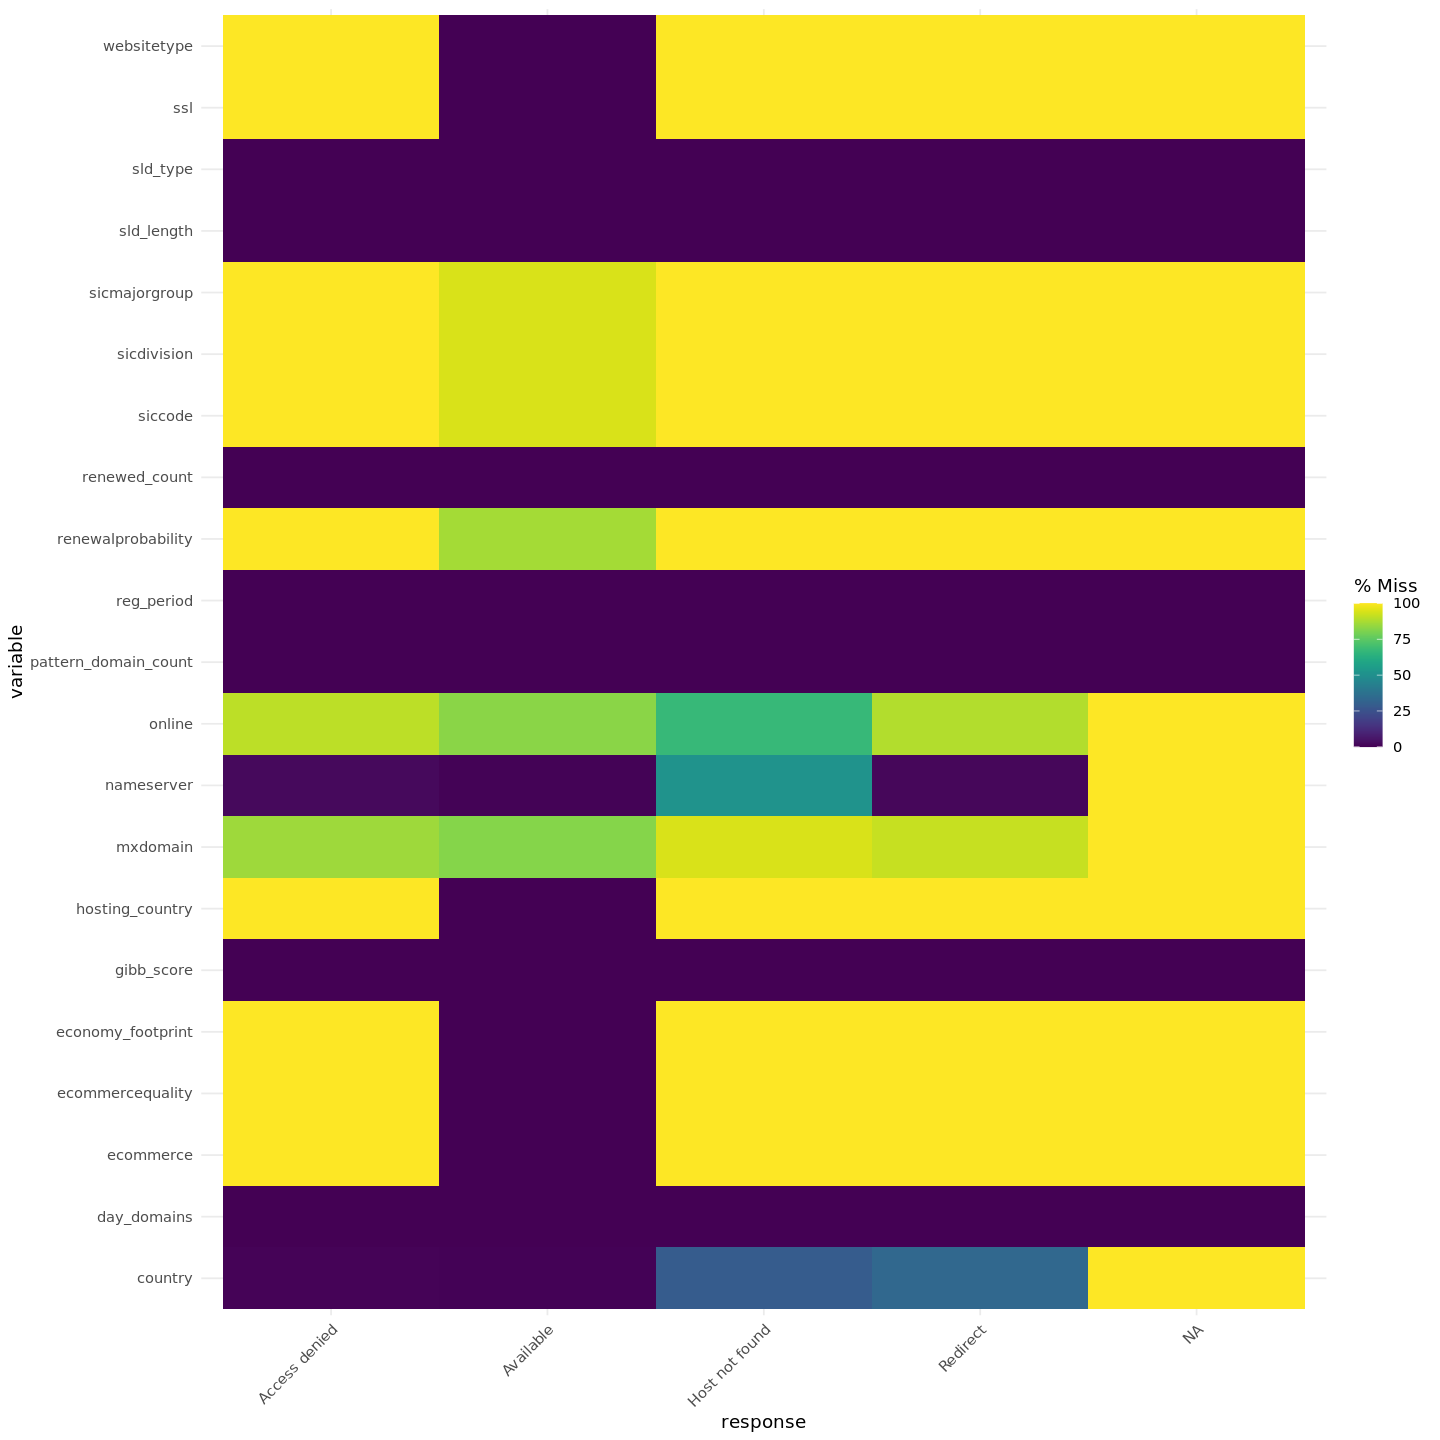

In [18]:
options(repr.plot.width=12, repr.plot.height=12)
gg_miss_fct(df[, c(radix_vars, dp_vars, unknown_vars)], response)

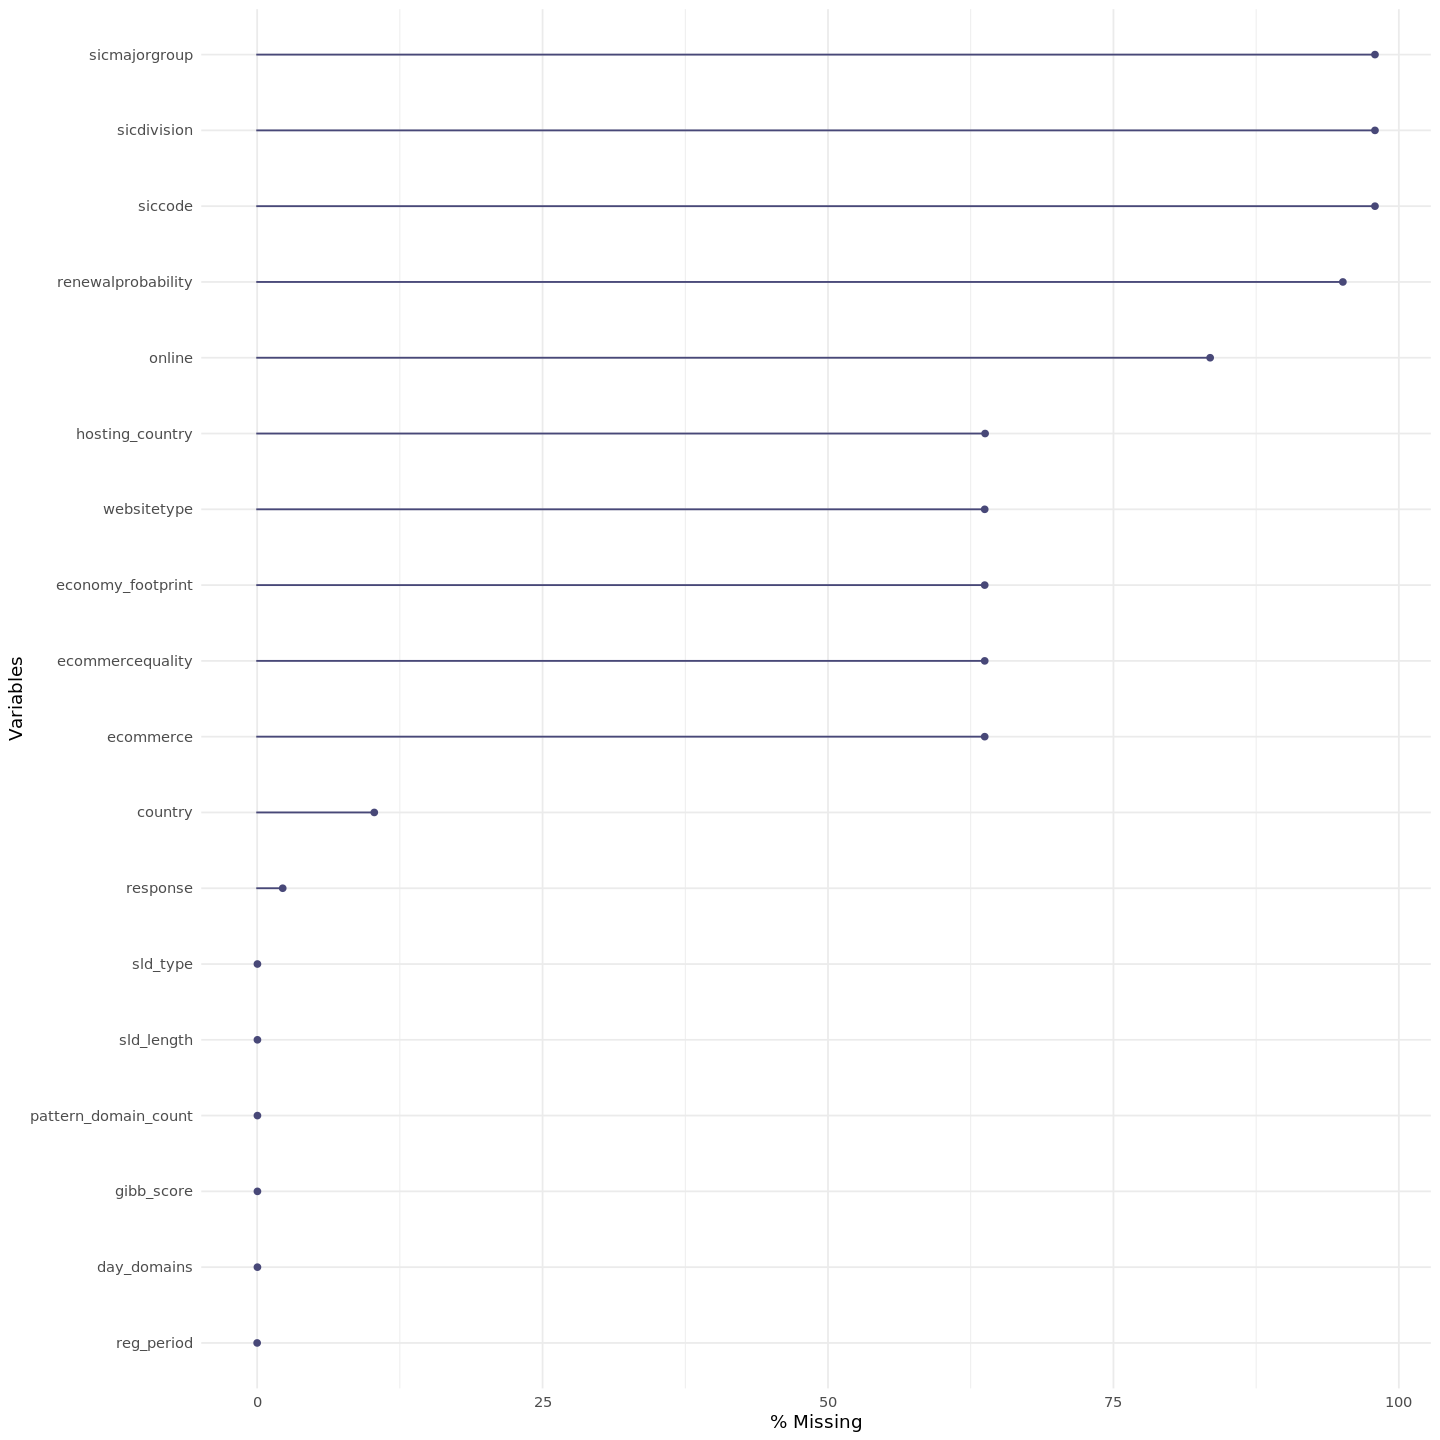

In [20]:
gg_miss_var(df[,c(radix_vars, dp_vars)], show_pct = TRUE)

## Available Websites only

In [21]:
mask <- df$response == "Available"
mask[is.na(mask)] = FALSE
avail = df[mask,]
table(df$response)


 Access denied      Available Host not found       Redirect 
         15733          15830           7576           3523 

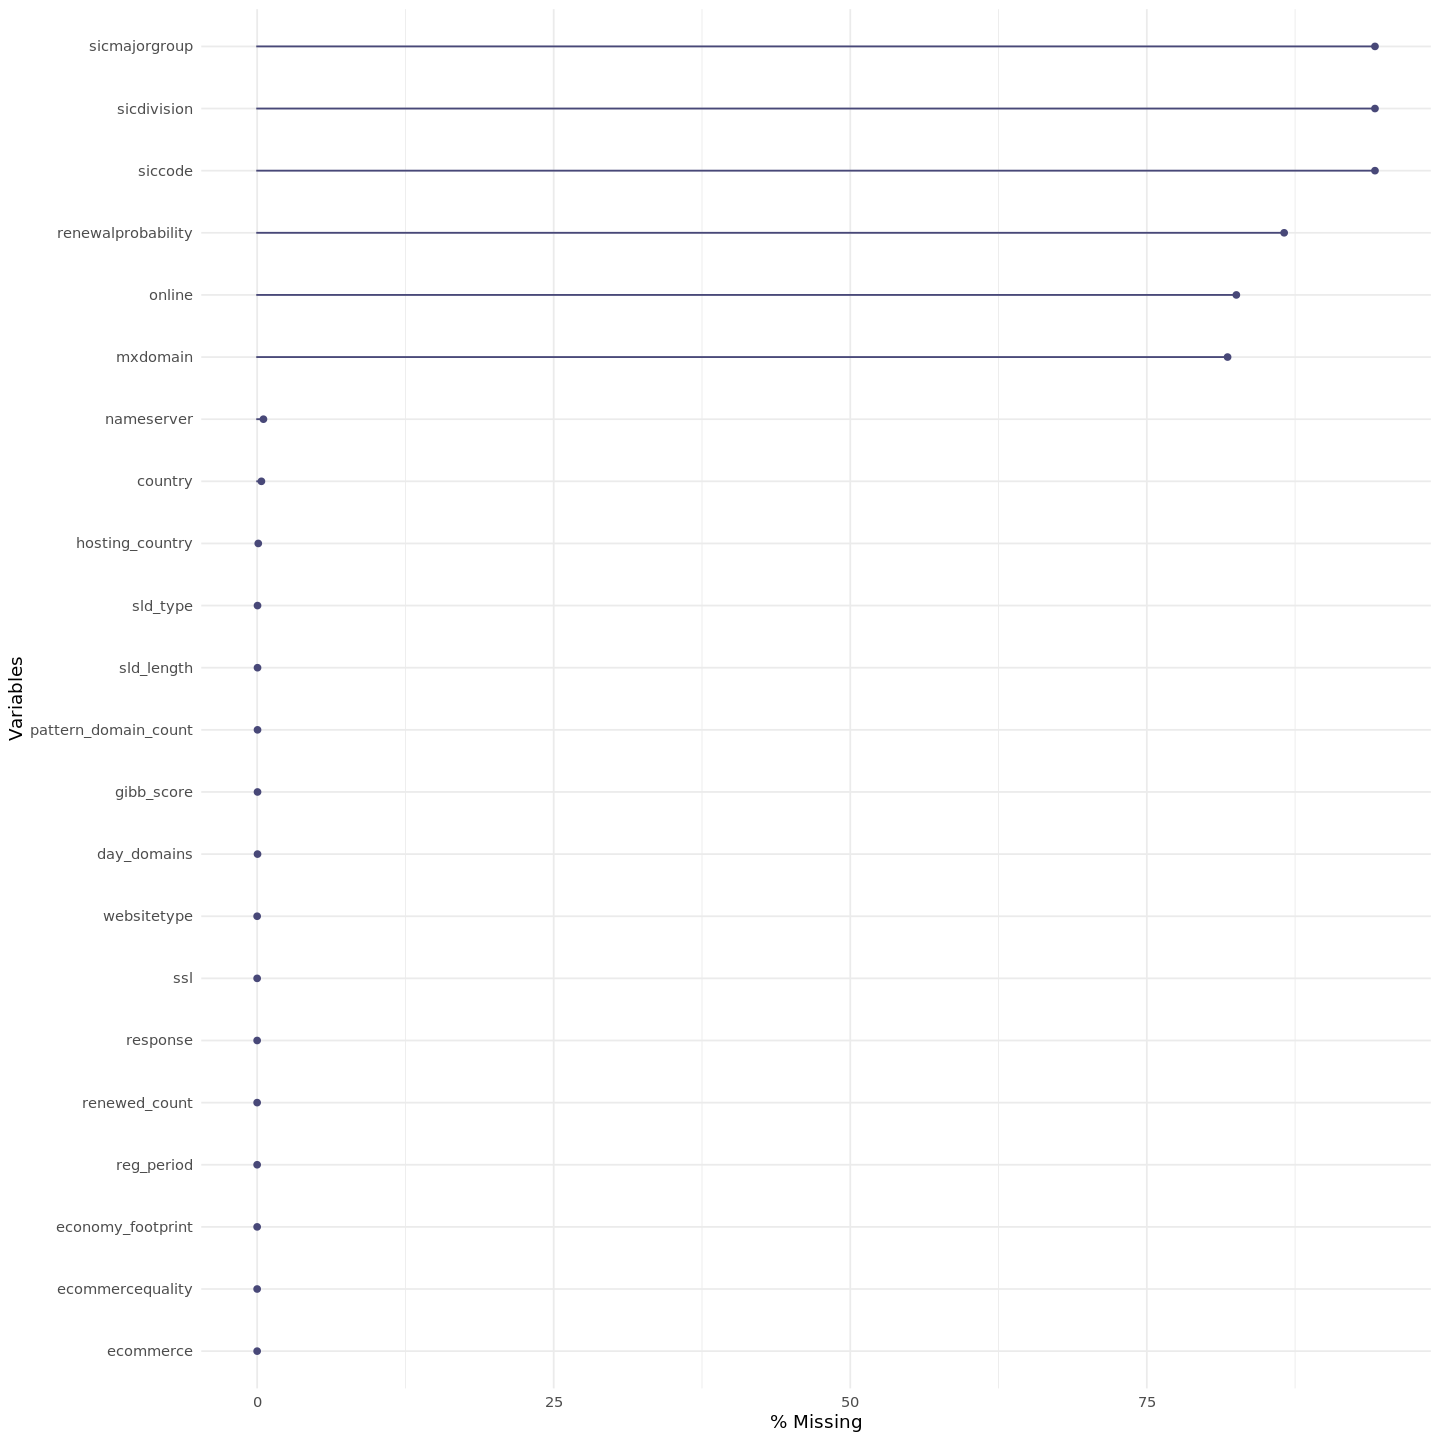

In [24]:
gg_miss_var(avail[,c(radix_vars, dp_vars, unknown_vars)], show_pct = TRUE)

In [25]:
# Select variables with less than 5% missing
miss_sum <- miss_var_summary(avail[,c(radix_vars, dp_vars, unknown_vars)])
thresh = 5
use_vars <- miss_sum %>% filter(pct_miss < thresh) %>% pull(variable)
use_vars <- c(use_vars, "target")

In [26]:
# Subset to rows where no variables missing; split traing test
use_df = avail[rowSums(is.na(avail[,use_vars])) == 0, use_vars]
print(paste0("Kept ", round(100 * nrow(use_df) / nrow(avail), 1), "% of records"))
set.seed(10)
train_ind <- sample(seq_len(nrow(use_df)), size = floor(0.75 * nrow(use_df)))
train <- use_df[train_ind, ]
test <- use_df[-train_ind, ]

[1] "Kept 99% of records"


In [27]:
# Train and test model
rf <- ranger(target ~ ., data = train, num.trees = 50, importance = "permutation", max.depth = 5)
pred <- predict(rf, test)
test$estimate <- pred$predictions
test$target <- as.factor(test$target)

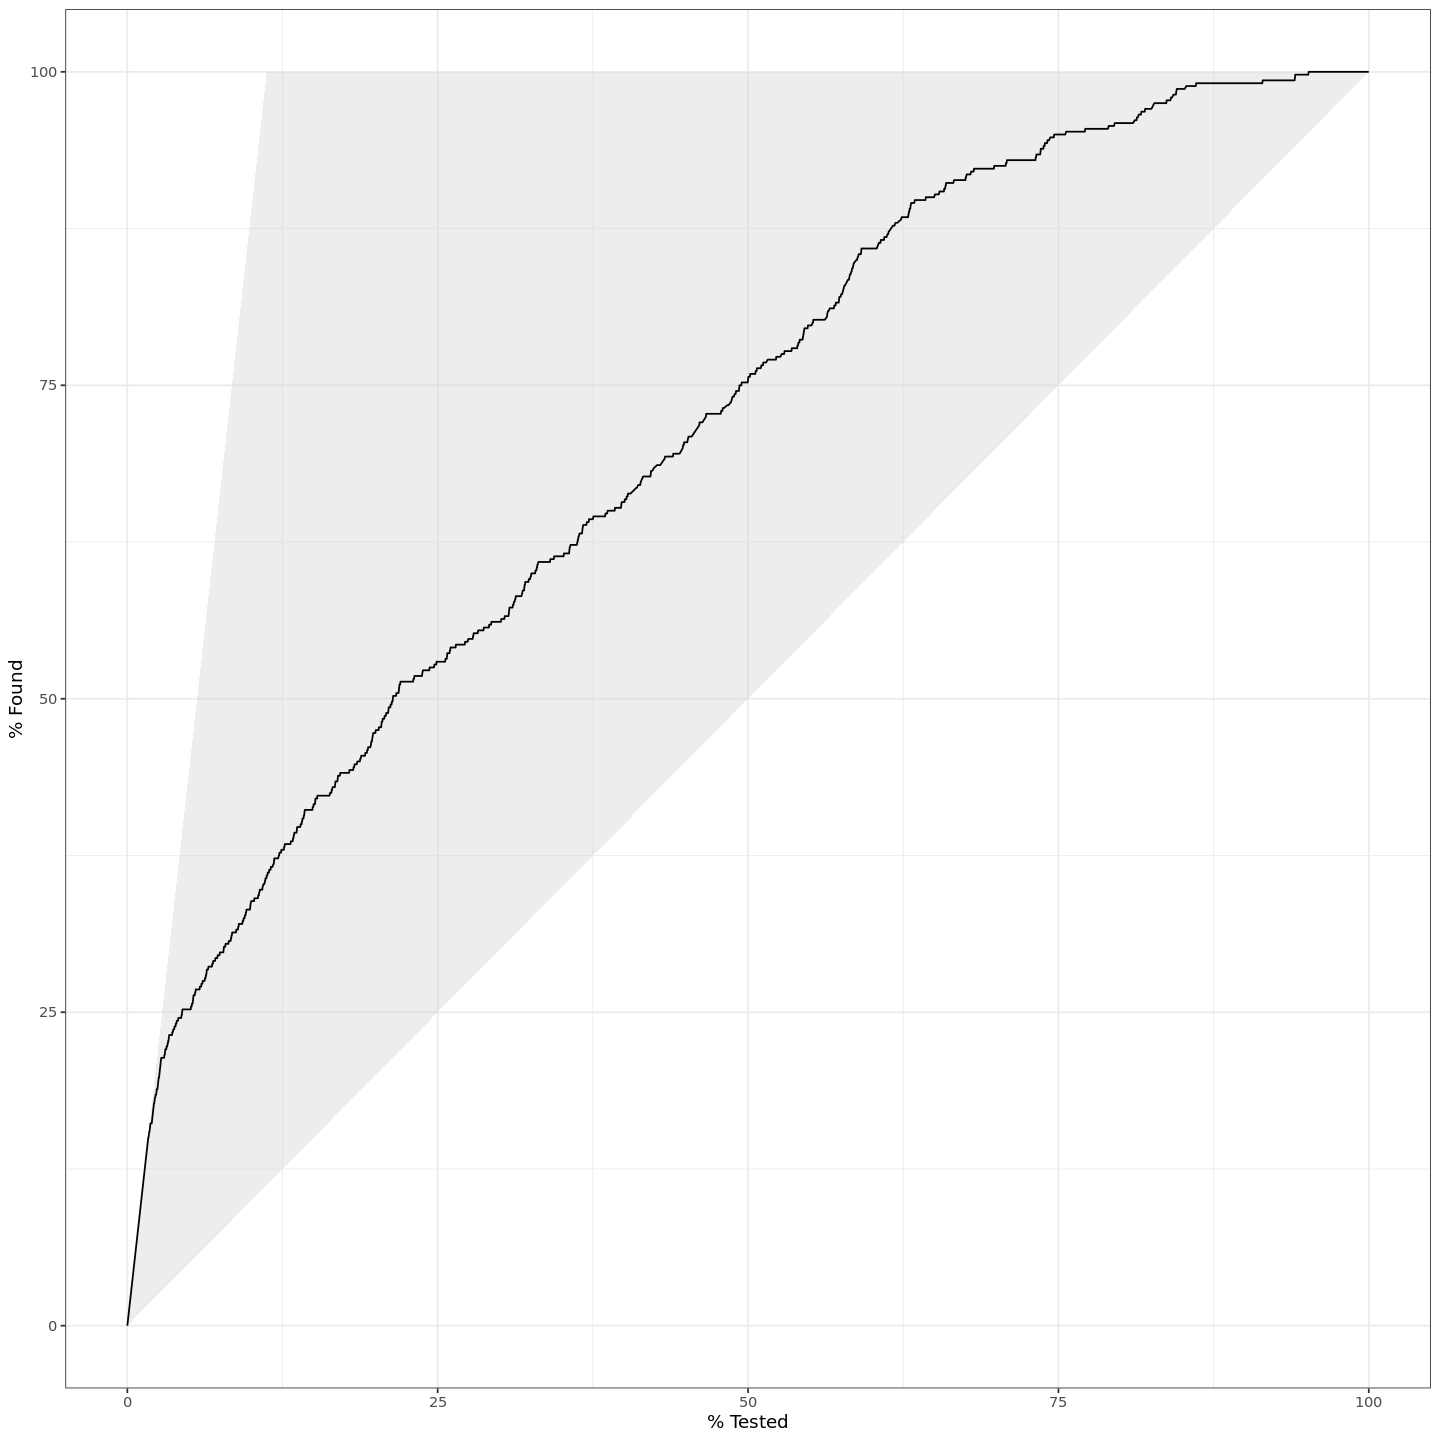

In [28]:
test %>% gain_curve(truth=target, estimate, event_level = "second") %>% autoplot()


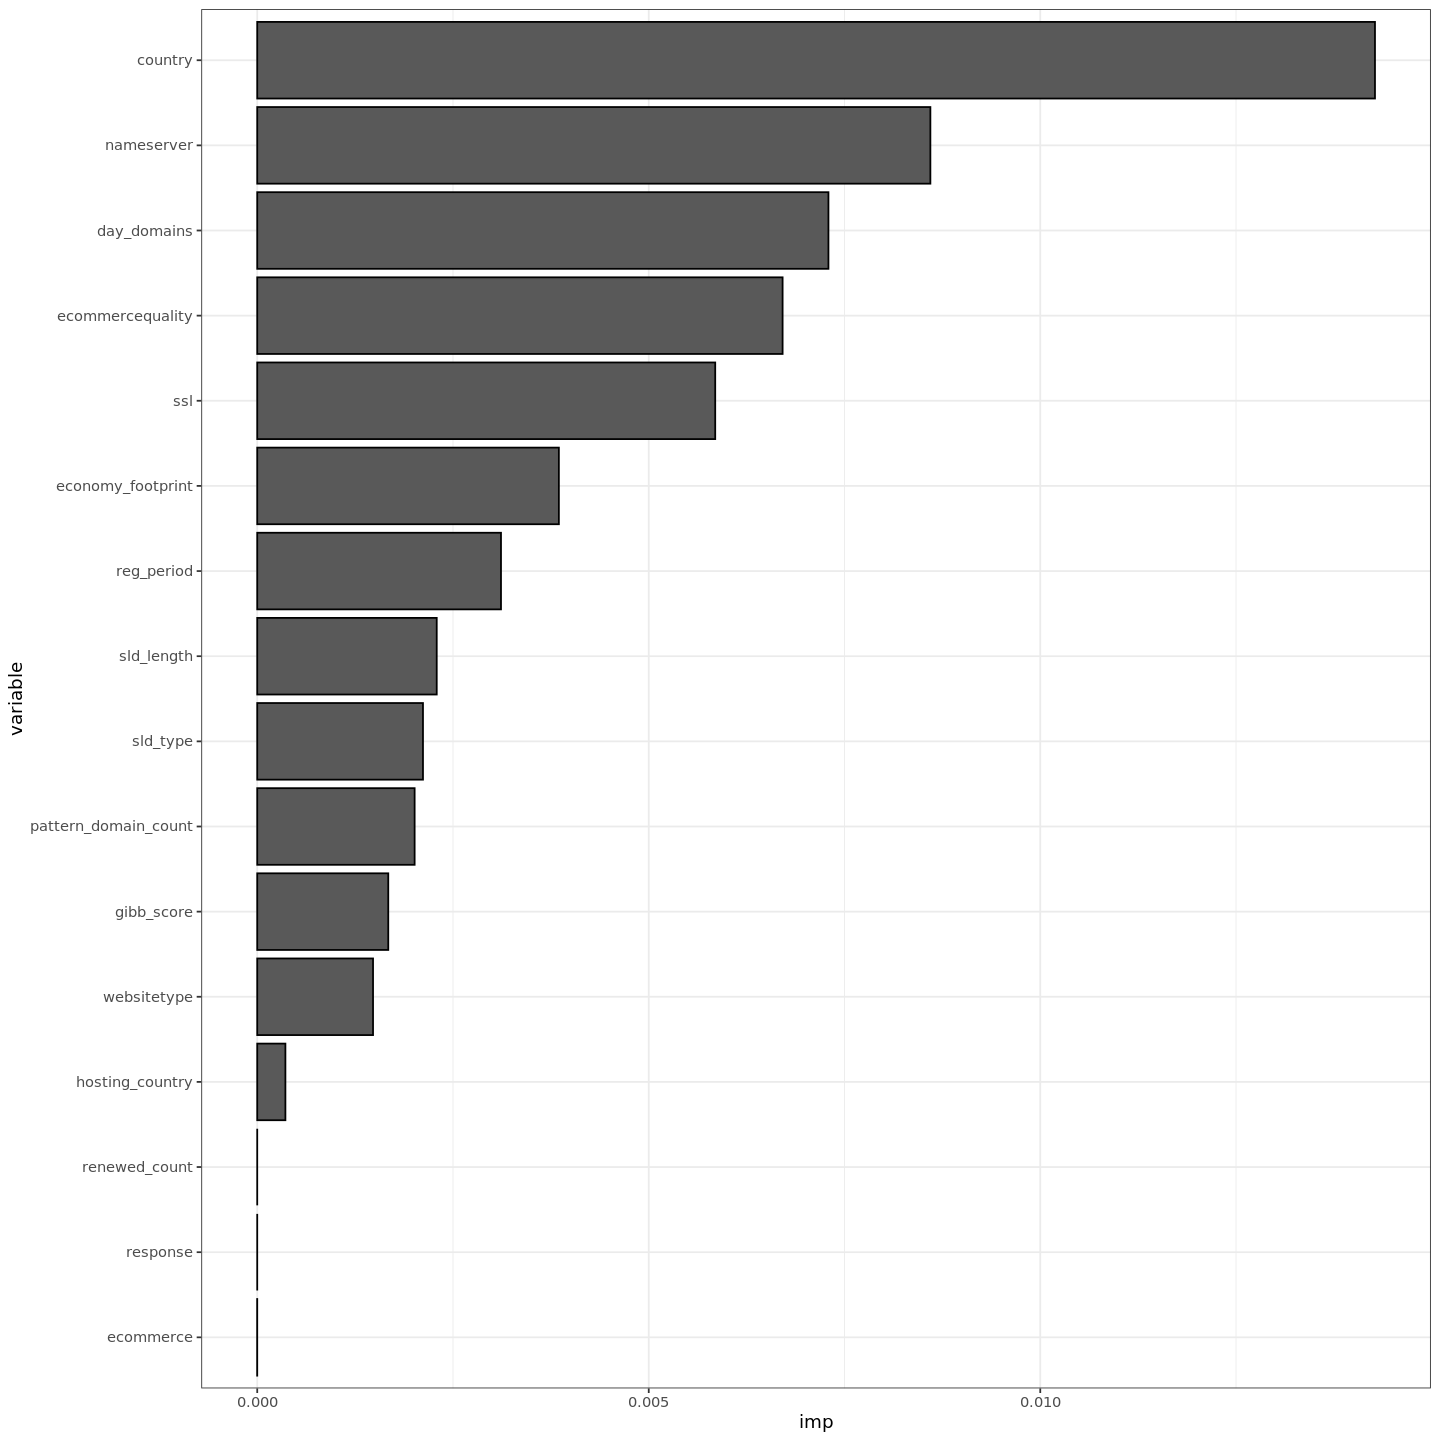

In [29]:
# Credit: https://stackoverflow.com/a/56306139
df1 <- data.frame(imp = rf$variable.importance)
df2 <- df1 %>% 
  tibble::rownames_to_column() %>% 
  dplyr::rename("variable" = rowname) %>% 
  dplyr::arrange(imp) %>%
  dplyr::mutate(variable = forcats::fct_inorder(variable))
ggplot2::ggplot(df2) +
  geom_col(aes(x = variable, y = imp),
           col = "black", show.legend = F) +
  coord_flip() +
  scale_fill_grey() +
  theme_bw()



In [30]:
renewal_by_factor <- function(col) {
    train %>% group_by(get(col)) %>% summarize(mu = mean(target), count = n()) %>% mutate(mu_perc = paste0(as.character(round(mu*100, digits= 2)),"%")) %>% arrange(desc(count)) %>% head(10)    
}
renewal_by_factor("country")

get(col),mu,count,mu_perc
<chr>,<dbl>,<int>,<chr>
US,0.19257951,3962,19.26%
CN,0.01713770,3326,1.71%
IN,0.05238095,630,5.24%
BR,0.11564626,588,11.56%
TR,0.03486239,545,3.49%
MY,0.88326848,257,88.33%
VN,0.04453441,247,4.45%
RU,0.05042017,238,5.04%
UA,0.02525253,198,2.53%


In [27]:
renewal_by_factor("nameserver")

get(col),mu,count,mu_perc
<chr>,<dbl>,<int>,<chr>
domaincontrol.com,0.129128278,7055,12.91%
cloudflare.com,0.309055118,1016,30.91%
dns.com,0.000000000,913,0%
dnsdun.com,0.000000000,694,0%
dnspod.net,0.009823183,509,0.98%
xundns.com,0.010309278,97,1.03%
hostgator.com,0.134831461,89,13.48%
namecheaphosting.com,0.144736842,76,14.47%
well-web.net,0.000000000,72,0%


In [31]:
renewal_by_factor("day_domains")

get(col),mu,count,mu_perc
<int>,<dbl>,<int>,<chr>
1136,0.052493438,381,5.25%
1370,0.023684211,380,2.37%
295,0.088652482,282,8.87%
777,0.014814815,270,1.48%
440,0.881679389,262,88.17%
422,0.004115226,243,0.41%
643,0.049504950,202,4.95%
595,0.045685279,197,4.57%
435,0.046875000,192,4.69%


In [31]:
imp_vars <- c("country", "nameserver", "day_domains", "ecommercequality", "ssl")
test %>% arrange(desc(estimate)) %>% select(country,nameserver,day_domains,ecommercequality,ssl,estimate, target) %>% head(100)

country,nameserver,day_domains,ecommercequality,ssl,estimate,target
<chr>,<chr>,<int>,<dbl>,<lgl>,<dbl>,<fct>
MY,cloudflare.com,440,27,TRUE,0.8086971,1
MY,cloudflare.com,440,27,TRUE,0.8061257,1
MY,cloudflare.com,440,27,TRUE,0.7996474,1
MY,cloudflare.com,440,27,TRUE,0.7961257,1
MY,cloudflare.com,440,27,TRUE,0.7961257,1
MY,cloudflare.com,440,27,TRUE,0.7958757,1
MY,cloudflare.com,440,27,TRUE,0.7958757,1
MY,cloudflare.com,440,27,TRUE,0.7958315,1
MY,cloudflare.com,440,27,TRUE,0.7958315,1


In [36]:
library(ppsr)

In [48]:
usevars <- c('pattern_domain_count','sld_length','gibb_score','sld_type','day_domains','reg_period',
             'response','websitetype','economy_footprint','online','ecommerce','ecommercequality','country',
              'nameserver','renewalprobability','siccode','sicdivision','sicmajorgroup',
              'ssl','renewed_count', 'target')
rem <- c('hosting_country', 'mxdomain')

In [ ]:
score_df(df[,usevars], cv_folds=1)

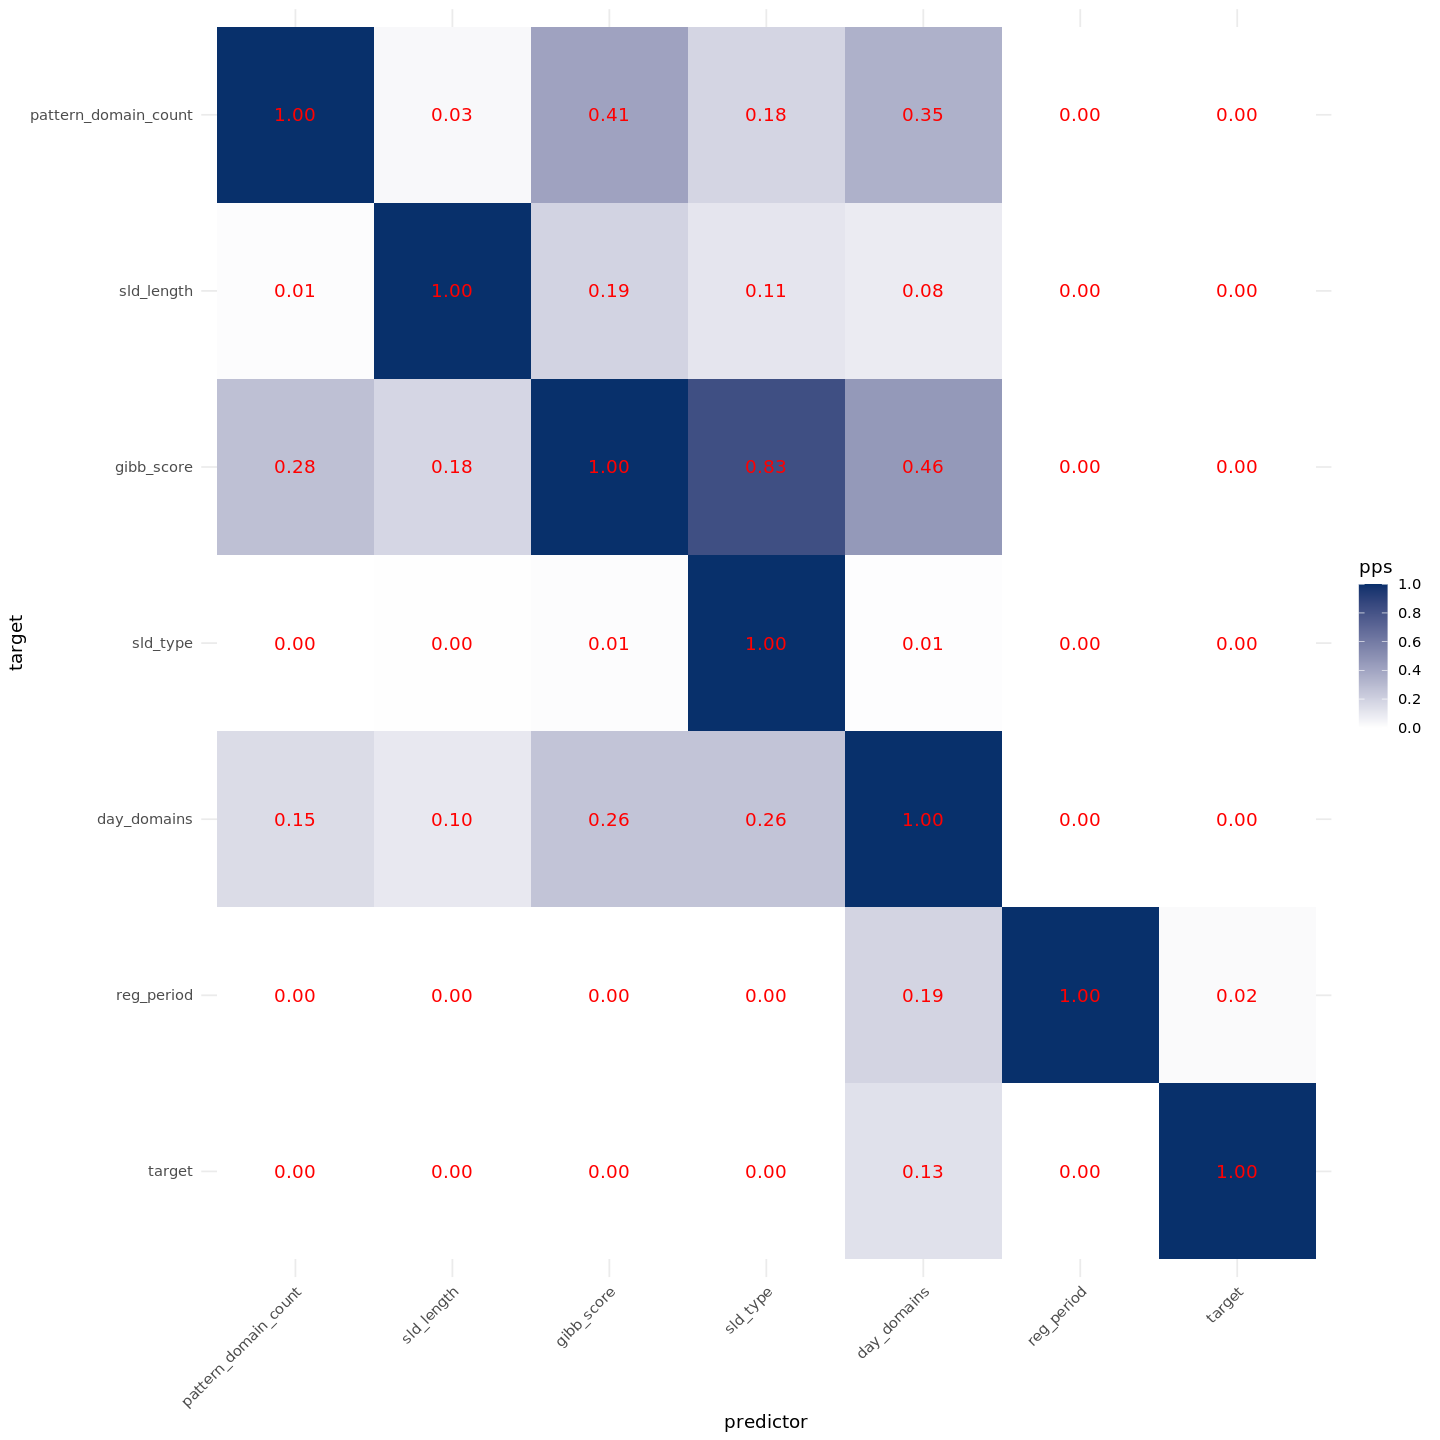

In [38]:
g <- df %>% select(any_of(c(radix_vars, 'target'))) %>% visualize_pps(do_parallel = TRUE, color_text="red")

g + theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [39]:
g <- df %>% select(any_of(c(dp_vars, 'target'))) %>% visualize_pps(do_parallel = TRUE, color_text="red")

g + theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [37]:
table(df$sld_type)


 hyphen-l hyphen-ln       idn         l        ln         n 
     1434       207       145     27314     10993      3535 

## EDA Pipeline for all tld-resellers

In [43]:
eda_pipeline <- function(df, tld, registrar, verbose=1) {
    # Subset data
    mask <- (df$tld == tld) & (df$registrar == registrar)
    mask[is.na(mask)] = FALSE
    df = df[mask, ]
    
    # Create target variable
    df[,'target'] <- as.integer(df[, "renewal_status"] == "Renewed")
    prev <- mean(df$target)
    
    # Plot missing data relationships to response
    gg_miss_fct(df[, c(radix_vars, dp_vars, unknown_vars)], response)

    # Subset to available data
    mask <- df$response == "Available"
    mask[is.na(mask)] = FALSE
    pct_avail <- mean(as.integer(mask))
    avail <- df[mask,]
    non_avail <- df[!mask,]
    
    # Select variables with less than 5% missing
    miss_sum <- miss_var_summary(avail[,c(radix_vars, dp_vars, unknown_vars)])
    thresh = 5
    avail_vars <- miss_sum %>% filter(pct_miss < thresh) %>% pull(variable)
    avail_vars <- c(avail_vars, "expiry_date", "target")
    
    miss_sum <- miss_var_summary(non_avail[,c(radix_vars, dp_vars, unknown_vars)])
    non_avail_vars <- miss_sum %>% filter(pct_miss < thresh) %>% pull(variable)
    non_avail_vars <- c(non_avail_vars, "expiry_date", "target")
    
    # Subset to rows where no variables missing
    keep_mask <- rowSums(is.na(avail[,avail_vars])) == 0
    avail = avail[keep_mask, avail_vars]
    keep_mask <- rowSums(is.na(non_avail[,non_avail_vars])) == 0
    non_avail = non_avail[keep_mask, non_avail_vars]

    
    # Get new prevalences
    prev_avail <- mean(avail$target)
    prev_non_avail <- mean(non_avail$target)
    
    if (verbose > 0) {
        cat(paste0(round(100 * prev, 1), "% of domains renewed\n"))
        cat(paste0(round(100 * pct_avail, 1), "% of responses available\n"))
        print(paste0("Kept ", round(100 * mean(keep_mask), 1), "% of the Available records"))
        print(paste0("Kept ", round(100 * mean(keep_mask), 1), "% of the Non-Available records"))    
        cat(paste0(round(100 * prev_avail, 1), "% of Available domains renewed\n"))
        cat(paste0(round(100 * prev_non_avail, 1), "% of Non Available domains renewed\n"))
    }
    
    # Split train test on time
    train_size = 0.75
    avail_date <- avail %>% arrange(expiry_date) %>% slice(round(0.75 * nrow(avail))) %>% pull(expiry_date)
    non_avail_date <- non_avail %>% arrange(expiry_date) %>% slice(round(0.75 * nrow(non_avail))) %>% pull(expiry_date)
    avail_train_mask <- avail$expiry_date <= avail_date
    non_avail_train_mask <- non_avail$expiry_date <= non_avail_date
    train_avail <- avail[avail_train_mask, ] %>% select(-expiry_date)
    test_avail <- avail[!avail_train_mask, ] %>% select(-expiry_date)
    train_non_avail <- non_avail[non_avail_train_mask, ] %>% select(-expiry_date)
    test_non_avail <- non_avail[!non_avail_train_mask, ] %>% select(-expiry_date)

    # Train and test Avaiable model
    set.seed(100)
    rf <- ranger(target ~ ., data = train_avail, num.trees = 50, importance = "permutation", max.depth = 5)
    pred <- predict(rf, test_avail)
    test_avail$est <- pred$predictions
    test_avail$target <- as.factor(test_avail$target)
    ap <- test_avail %>% average_precision(truth = target, est, event_level = "second") %>% pull(.estimate)
    auc <- test_avail %>% roc_auc(truth = target, est, event_level = "second") %>% pull(.estimate)
    gini <- test_avail %>% gain_capture(truth = target, est, event_level = "second") %>% pull(.estimate)

    # Train and test Non Avaiable model
    set.seed(100)
    rf_non <- ranger(target ~ ., data = train_non_avail, num.trees = 50, importance = "permutation", max.depth = 5)
    pred <- predict(rf_non, test_non_avail)
    test_non_avail$est <- pred$predictions
    test_non_avail$target <- as.factor(test_non_avail$target)
    ap_non <- test_non_avail %>% average_precision(truth = target, est, event_level = "second") %>% pull(.estimate)
    auc_non <- test_non_avail %>% roc_auc(truth = target, est, event_level = "second") %>% pull(.estimate)
    gini_non <- test_non_avail %>% gain_capture(truth = target, est, event_level = "second") %>% pull(.estimate)
    
    if (verbose > 0) {
        cat(paste0("Available Average Precision: ", round(ap, 3), "\n"))
        cat(paste0("Available AUC: ", round(auc, 3), "\n"))
        cat(paste0("Available Gini: ", round(gini, 3), "\n"))
        cat(paste0("Non Available Average Precision: ", round(ap_non, 3), "\n"))
        cat(paste0("Non Available AUC: ", round(auc_non, 3), "\n"))
        cat(paste0("Non Available Gini: ", round(gini_non, 3), "\n"))

        # Plot avail Variable importances-- credit: https://stackoverflow.com/a/56306139
        df1 <- data.frame(imp = rf$variable.importance)
        df2 <- df1 %>% 
          tibble::rownames_to_column() %>% 
          dplyr::rename("variable" = rowname) %>% 
          dplyr::arrange(imp) %>%
          dplyr::mutate(variable = forcats::fct_inorder(variable))
        g <- ggplot2::ggplot(df2) +
          geom_col(aes(x = variable, y = imp),
                   col = "black", show.legend = F) +
          coord_flip() +
          scale_fill_grey() +
          theme_bw()
        plot(g)
        
        # Plot non avail Variable importances-- credit: https://stackoverflow.com/a/56306139
        df1 <- data.frame(imp = rf_non$variable.importance)
        df2 <- df1 %>% 
          tibble::rownames_to_column() %>% 
          dplyr::rename("variable" = rowname) %>% 
          dplyr::arrange(imp) %>%
          dplyr::mutate(variable = forcats::fct_inorder(variable))
        g <- ggplot2::ggplot(df2) +
          geom_col(aes(x = variable, y = imp),
                   col = "black", show.legend = F) +
          coord_flip() +
          scale_fill_grey() +
          theme_bw() 
        plot(g)
    }

    
    # Create response list
    list(rf_avail=rf, rf_non_avail=rf_non, prev=prev, pct_avail=pct_avail, ap_avail=ap, auc_avail=auc, gini_avail=gini, ap_non_avail=ap_non, 
         auc_non_avail=auc_non, gini_non_avail=gini_non, rf_avail_imp=rf$variable.importance, rf_non_avail_imp=rf_non$variable.importance)

}

In [63]:
big_reg <- df$registrar %in% c("Go Daddy", "Namecheap")
big_reg[is.na(big_reg)] <- F
tab <- table(df[big_reg,]$tld, df[big_reg,]$registrar)
round(100 * tab / colSums(tab), 2)


         
          Go Daddy Namecheap
  fun         2.55      7.54
  host        0.40     20.72
  in.net      0.00      0.03
  online     16.51     28.93
  press       0.17      1.45
  pw          2.48     34.53
  site       21.53     26.51
  space       7.72     17.93
  store       8.48      3.14
  tech        1.71      4.52
  website     5.90     11.27

In [48]:
tlds <- c("site", "online", "website", "space", "store", "tech")
registrars <- c("Go Daddy", "Namecheap")
reg = registrars[1]
imps <- data.frame()
for (tld in tlds) {
    l <- eda_pipeline(df, tld, reg, verbose=0)
    name <- quo_name(tld)
    imp <- data.frame(l$rf_avail_imp) %>% rownames_to_column() %>% rename(!!name := l.rf_avail_imp)
    if (length(imps) == 0)  imps <- imp
    else {
        imps <- imps %>% left_join(imp, by="rowname")
    }
}
imps

rowname,site,online,website,space,store,tech
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
nameserver,1.050818e-02,1.264701e-03,0.0007618826,6.382216e-03,0.0001760400,8.862718e-04
country,1.439716e-02,4.977483e-03,0.0200547161,2.209286e-02,0.0083823618,4.974255e-03
hosting_country,6.875485e-04,1.516706e-04,0.0036383367,1.902318e-03,0.0009965984,5.812142e-04
pattern_domain_count,1.524442e-03,1.034094e-03,0.0052096737,1.117632e-03,0.0006705290,3.534522e-04
sld_length,5.288591e-03,4.472623e-04,0.0021456049,8.936139e-04,0.0001511549,2.613805e-04
gibb_score,1.437978e-03,2.878378e-04,0.0004275175,1.639027e-03,0.0001588271,1.138672e-03
sld_type,5.187110e-04,7.250226e-04,0.0008700443,3.165603e-03,0.0001346794,1.720771e-05
day_domains,9.658541e-03,2.078631e-03,0.0085341593,1.041224e-02,0.0015211170,6.486481e-04
reg_period,3.378353e-03,9.064972e-03,0.0023361649,1.620680e-03,0.0063447700,2.168244e-03


In [51]:
imps %>% pivot_longer(cols=all_of(tlds), names_to="variable", values_to="value") %>%
    group_by(variable, value) %>%
    summarise(n = n())

`summarise()` has grouped output by 'variable'. You can override using the `.groups` argument.



variable,value,n
<chr>,<dbl>,<int>
online,-3.629791e-06,1
online,0.000000e+00,2
online,1.516706e-04,1
online,2.053828e-04,1
online,2.878378e-04,1
online,3.186433e-04,1
online,4.472623e-04,1
online,5.242574e-04,1
online,7.250226e-04,1


In [21]:
d <- data.frame()
for (i in seq(length(tlds))) {
    tld = tlds[i]
    d[,tld] = imps
}
d

ERROR: Error in `[<-.data.frame`(`*tmp*`, , tld, value = c(nameserver = 0.0105081845548473, : replacement has 96 rows, data has 0


In [23]:
is.vector(l$rf_avail_imp)

[1] TRUE

In [24]:
data.frame(l$rf_avail_imp)

,l.rf_avail_imp
,<dbl>
pattern_domain_count,3.534522e-04
sld_length,2.613805e-04
gibb_score,1.138672e-03
sld_type,1.720771e-05
day_domains,6.486481e-04
country,4.974255e-03
nameserver,8.862718e-04
hosting_country,5.812142e-04
reg_period,2.168244e-03


In [33]:
l1 <- eda_pipeline(df, "site", "Go Daddy", verbose=0)
l2 <- eda_pipeline(df, "online", "Namecheap", verbose=0)

imp1 <- data.frame(l1$rf_avail_imp)
imp2 <- data.frame(l2$rf_avail_imp)
imp1

7.5% of domains renewed
8% of domains renewed


,l1.rf_avail_imp
,<dbl>
nameserver,1.050818e-02
country,1.439716e-02
hosting_country,6.875485e-04
pattern_domain_count,1.524442e-03
sld_length,5.288591e-03
gibb_score,1.437978e-03
sld_type,5.187110e-04
day_domains,9.658541e-03
reg_period,3.378353e-03


In [35]:
imp2

,l2.rf_avail_imp
,<dbl>
country,2.262485e-03
nameserver,9.650397e-04
hosting_country,2.867156e-04
pattern_domain_count,4.027911e-04
sld_length,3.538961e-04
gibb_score,9.888567e-05
sld_type,3.953727e-04
day_domains,1.847587e-03
reg_period,5.414605e-04


In [40]:
imp = imp1 %>% rownames_to_column() %>% left_join(rownames_to_column(imp2), by="rowname")

In [41]:
imp

rowname,l1.rf_avail_imp,l2.rf_avail_imp
<chr>,<dbl>,<dbl>
nameserver,1.050818e-02,9.650397e-04
country,1.439716e-02,2.262485e-03
hosting_country,6.875485e-04,2.867156e-04
pattern_domain_count,1.524442e-03,4.027911e-04
sld_length,5.288591e-03,3.538961e-04
gibb_score,1.437978e-03,9.888567e-05
sld_type,5.187110e-04,3.953727e-04
day_domains,9.658541e-03,1.847587e-03
reg_period,3.378353e-03,5.414605e-04
